# Imports

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.optim as optim
from matplotlib import pyplot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load Data

In [14]:
# Load datasets
data = pd.read_csv('../data/cvd_transformed.csv')
data

,id,age_days,age_year,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse,bmi_clasification,pulse_clasification
0,0,18393,50.391781,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,30,Peso normal,2
1,1,20228,55.419178,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,50,Obesidad,4
2,2,18857,51.663014,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,60,Peso normal,4
3,3,17623,48.282192,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,50,Sobrepeso,4
4,4,17474,47.873973,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,40,Peso normal,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61834,99988,20609,56.463014,1,159,72.0,130,90,2,2,0,0,1,0,28.479886,40,Sobrepeso,3
61835,99991,19699,53.969863,1,172,70.0,130,90,1,1,0,0,1,1,23.661439,40,Peso normal,3
61836,99993,19240,52.712329,2,168,76.0,120,80,1,1,1,0,1,0,26.927438,40,Sobrepeso,3
61837,99998,22431,61.454795,1,163,72.0,135,80,1,2,0,0,0,1,27.099251,55,Sobrepeso,4


In [15]:
# Define the features and target variable
features = ['age_year', 'cholesterol', 'gluc','smoke', 'alco','active', 'bmi' , 'pulse']
X = data[features]
y = data['cardio']

# Escalamiento de datos
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print("Datos")
print(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Datos
[[-0.41252876 -0.51957914 -0.38479629 ...  0.49289452 -1.12322809
  -1.70180269]
 [ 0.33066899  2.48212624 -0.38479629 ...  0.49289452  1.82539772
   0.78361434]
 [-0.22460301  2.48212624 -0.38479629 ... -2.02883165 -0.77271049
   2.02632286]
 ...
 [-0.06948326 -0.51957914 -0.38479629 ...  0.49289452  0.00528188
  -0.45909417]
 [ 1.2229113  -0.51957914  1.38952461 ... -2.02883165  0.04437073
   1.4049686 ]
 [ 0.45703285  0.98127355 -0.38479629 ...  0.49289452 -0.45290544
  -0.45909417]]


# DataLoader

In [16]:
# Ensure X_train and y_train are numpy arrays
X_train = X_train.to_numpy() if hasattr(X_train, 'to_numpy') else X_train
y_train = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else y_train

X_test = X_test.to_numpy() if hasattr(X_test, 'to_numpy') else X_test
y_test = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # Use long for classification labels

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
# Create DataLoaders
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Dimensionalidad de datos X: {X.shape}")
    print(f"Dimensionalidad de categorías y: {y.shape}, tipo de categorías: {y.dtype}")
    break

Dimensionalidad de datos X: torch.Size([64, 8])
Dimensionalidad de categorías y: torch.Size([64]), tipo de categorías: torch.int64


# Neural Network

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device a utulizar: {device}")

Device a utulizar: cpu


In [19]:
# Define architecture of neural network

class RedNeuronal(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 64),    # Entrada: 8, Salida: 64
            nn.ReLU(),
            nn.Linear(64, 128),  # Entrada: 64, Salida: 128
            nn.ReLU(),
            nn.Linear(128, 256), # Entrada: 128, Salida: 256
            nn.ReLU(),
            nn.Linear(256, 512), # Entrada: 256, Salida: 512
            nn.ReLU(),
            nn.Linear(512, 128), # Entrada: 512, Salida: 128
            nn.ReLU(),
            nn.Linear(128, 1)    # Entrada: 128, Salida: 1 (clasificación binaria)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

# Inicialización
model = RedNeuronal().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Entrenamiento
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Predicción y pérdida
        pred = model(X)
        loss = loss_fn(pred.squeeze(dim=1), y.float())  # Ajustar dimensiones

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Valor de función de pérdida: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Evaluación
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred.squeeze(dim=1), y.float()).item()
            correct += ((torch.sigmoid(pred) > 0.68).squeeze(dim=1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Fase de prueba: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# Training

In [20]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Valor de función de pérdida: 0.699346  [   64/49471]
Valor de función de pérdida: 0.609982  [ 6464/49471]
Valor de función de pérdida: 0.522754  [12864/49471]
Valor de función de pérdida: 0.567242  [19264/49471]
Valor de función de pérdida: 0.500739  [25664/49471]
Valor de función de pérdida: 0.595881  [32064/49471]
Valor de función de pérdida: 0.606530  [38464/49471]
Valor de función de pérdida: 0.681113  [44864/49471]
Fase de prueba: 
 Accuracy: 64.9%, Avg loss: 0.600424 

Epoch 2
-------------------------------
Valor de función de pérdida: 0.570520  [   64/49471]
Valor de función de pérdida: 0.541063  [ 6464/49471]
Valor de función de pérdida: 0.493659  [12864/49471]
Valor de función de pérdida: 0.528859  [19264/49471]
Valor de función de pérdida: 0.701162  [25664/49471]
Valor de función de pérdida: 0.528124  [32064/49471]
Valor de función de pérdida: 0.592069  [38464/49471]
Valor de función de pérdida: 0.610819  [44864/49471]
Fase de prueba: 

# Evaluation

In [24]:
# Evaluación del modelo

# Poner el modelo en modo de evaluación
model.eval()

# Inicializar listas para almacenar predicciones y etiquetas
all_probs = []  # Probabilidades continuas
all_preds = []  # Etiquetas predichas binarias
all_labels = [] # Etiquetas verdaderas

# Iterar sobre el dataloader de prueba
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Obtener predicciones
        outputs = model(X_batch)  # Logits (salidas no transformadas)
        probs = torch.sigmoid(outputs).squeeze(dim=1)  # Convertir a probabilidades
        preds = (probs > 0.68).long()  # Aplicar umbral para convertir a etiquetas binarias
        
        # Almacenar resultados
        all_probs.extend(probs.cpu().numpy())  # Probabilidades continuas
        all_preds.extend(preds.cpu().numpy())  # Etiquetas binarias
        all_labels.extend(y_batch.cpu().numpy())  # Etiquetas verdaderas

# Calcular métricas
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auroc = roc_auc_score(all_labels, all_probs)  # Usar probabilidades continuas para AUROC

# Mostrar resultados
print("Resultados de evaluación")
print(f"F1-Score: {f1:.4f}")
print(f"Precisión: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUROC: {auroc:.4f}")

# Matriz de confusión
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Matriz de confusión:\n", conf_matrix)


Resultados de evaluación
F1-Score: 0.4956
Precisión: 0.7525
Recall: 0.3695
AUROC: 0.7430
Matriz de confusión:
 [[5927  698]
 [3621 2122]]


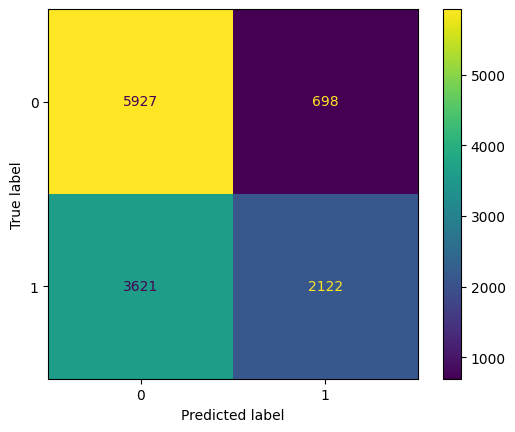

In [25]:
# Plot confussion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

Text(0.5, 0, 'False Positive Rate')

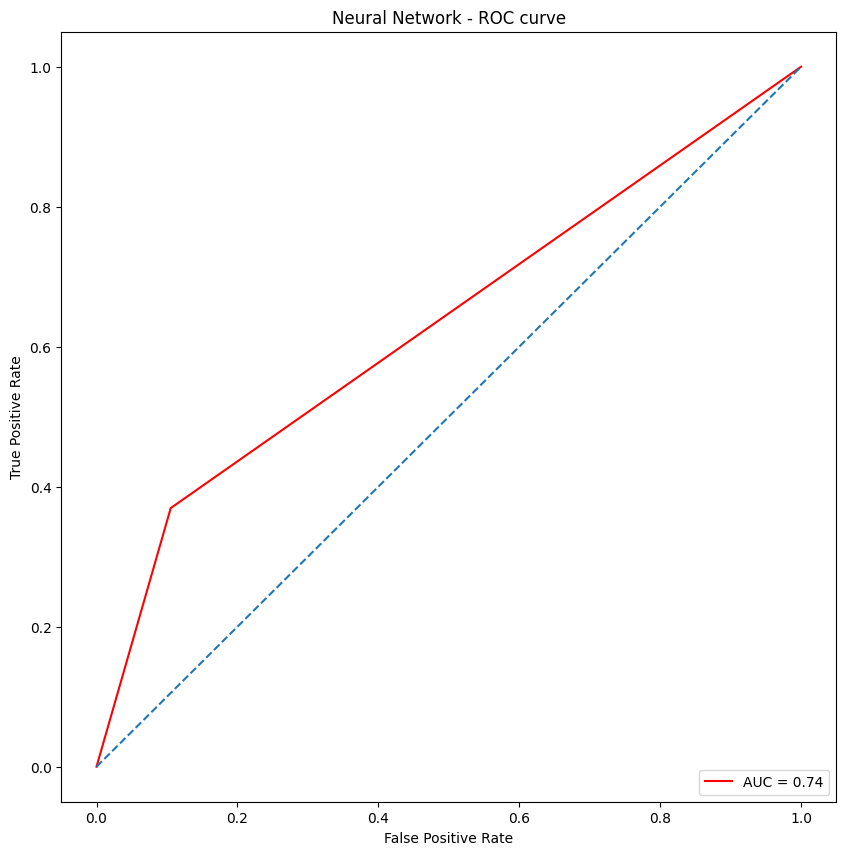

In [28]:
# Plot ROC curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(all_labels, all_preds)
#auc_roc = roc_auc_score(all_labels, all_preds, average='weighted')
plt.figure(figsize=(10,10))
plt.title('Neural Network - ROC curve')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = f'AUC = {auroc:.2f}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')